In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np

In [2]:
data = pd.read_csv('caso_full.csv')

In [3]:
data.columns

Index(['city', 'city_ibge_code', 'date', 'epidemiological_week',
       'estimated_population', 'estimated_population_2019', 'is_last',
       'is_repeated', 'last_available_confirmed',
       'last_available_confirmed_per_100k_inhabitants', 'last_available_date',
       'last_available_death_rate', 'last_available_deaths', 'order_for_place',
       'place_type', 'state', 'new_confirmed', 'new_deaths'],
      dtype='object')

In [4]:
mapping = {}
mapping['AC'] = "Norte"
mapping['AL'] = "Nordeste"
mapping['AM'] = "Norte"
mapping['AP'] = "Norte"
mapping['BA'] = "Nordeste"
mapping['CE'] = "Nordeste"
mapping['DF'] = "Centro Oeste"
mapping['ES'] = "Sudeste"
mapping['GO'] = "Centro Oeste"
mapping['MA'] = "Nordeste"
mapping['MG'] = "Sudeste"
mapping['MS'] = "Centro Oeste"
mapping['MT'] = "Centro Oeste"
mapping['PA'] = "Norte"
mapping['PB'] = "Nordeste"
mapping['PE'] = "Nordeste"
mapping['PI'] = "Nordeste"
mapping['PR'] = "Sul"
mapping['RJ'] = "Sudeste"
mapping['RN'] = "Nordeste"
mapping['RO'] = "Centro Oeste"
mapping['RR'] = "Norte"
mapping['RS'] = "Sul"
mapping['SC'] = "Sul"
mapping['SE'] = "Nordeste"
mapping['SP'] = "Sudeste"
mapping['TO'] = "Norte"

In [5]:
# field = "last_available_confirmed_per_100k_inhabitants"
field = "total_casos"

In [6]:
data = data[(data['city'].isnull() == False) & (data['is_repeated'] == False)]
data["total_casos"] = data["last_available_confirmed_per_100k_inhabitants"] * data["estimated_population_2019"]
columns_to_drop = ['city','place_type','last_available_confirmed',
                   'last_available_date','estimated_population',
                   'is_last','is_repeated']
data.drop(columns=columns_to_drop,inplace=True)
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')
data['region'] = data.apply (lambda row: mapping[row["state"]], axis=1)

In [7]:
data["state"].nunique()

27

In [8]:
data.region.unique()

array(['Norte', 'Nordeste', 'Centro Oeste', 'Sudeste', 'Sul'],
      dtype=object)

In [9]:
min_date = data["date"].min()
max_date = data["date"].max()
delta = max_date - min_date
dates = pd.date_range(start=min_date, end=max_date, freq='D')
def interpolate_mun(mun_data):
    #series = mun_data[["last_available_confirmed_per_100k_inhabitants","date","region"]]
    series = mun_data[[field,"date","region"]]
    region_ = series.iloc[0].region
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    series["region"] = region_
    return series

In [10]:
#agg_data = data[["last_available_confirmed_per_100k_inhabitants","city_ibge_code","region","date"]].groupby("city_ibge_code").apply(lambda x: interpolate_mun(x))
agg_data = data[[field,"city_ibge_code","region","date"]].groupby("city_ibge_code").apply(lambda x: interpolate_mun(x))

In [11]:
agg_data = agg_data.reset_index()

In [12]:
agg_data.rename(columns={"level_1": "date"},inplace=True)

In [13]:
agg_data = agg_data[[field,"region","date"]].groupby(['region',"date"]).sum()

In [14]:
grouped = agg_data.reset_index().groupby("region")

In [15]:
X = np.zeros((len(grouped),delta.days + 1))
for i,(group, data_) in enumerate(grouped):
    #series = data_[["last_available_confirmed_per_100k_inhabitants","date"]]
    series = data_[[field,"date"]]
    print(i,group)
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    X[i,:] = series.values.reshape(len(series))

0 Centro Oeste
1 Nordeste
2 Norte
3 Sudeste
4 Sul


In [16]:
data.region.unique()

array(['Norte', 'Nordeste', 'Centro Oeste', 'Sudeste', 'Sul'],
      dtype=object)

In [17]:
X.shape

(5, 591)

In [18]:
l = ["Centro Oeste","Nordeste","Norte","Sudeste","Sul"]

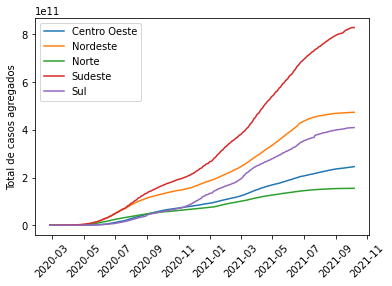

In [19]:
for i in range(5):
    plt.plot(dates,X[i,:],label=l[i])
plt.legend()
plt.ylabel("Total de casos agregados")
plt.xticks(rotation=45)
plt.show()

In [20]:
dim = int(np.floor(X.shape[1]/7))
Y = np.zeros(( 5, dim))
for t in range(dim):
    for i in range(5):
        if t < dim - 1:
            Y[i,t] = np.sum(X[i,7*t:7*t+7])
        else:
            Y[i,t] = np.sum(X[i,7*t:])

In [21]:
Y.shape

(5, 84)

In [22]:
X.shape

(5, 591)

In [23]:
#Constroi matriz de Adjacencias:
# 0 - Norte
# 1 - Centro Oeste
# 2 - Nordeste
# 3 - Sudeste
# 4 - Sul

In [24]:
A = np.zeros((5,5))

In [25]:
A[0,0] = A[0,1] = A[0,2] = A[1,0] = A[2,0] = 1
A[1,1] = A[1,2] = A[1,3] = A[1,4] = A[2,1] = A[3,1] = A[4,1] = 1
A[2,2] = A[2,3] = A[3,2] = 1
A[3,3] = A[3,4] = A[4,3] = 1
A[4,4] = 1

In [26]:
np.allclose(A,A.T)

True

In [27]:
n = 1
k = 3

In [28]:
# shape = Y.shape
# # shape[1] -= n
# Y_hat = cp.Variable(shape)
# C = cp.Variable((shape[0],k))
# constraints = []
# for i in range(shape[0]):
#     for t in range(shape[1]-n):
#         terms = []
#         for l in range(min(t,k)):
#             for j in range(5):
#                 terms.append(C[j,l]*A[i,j]*Y[j,t-l])
#         constraints += [Y_hat[i,t+n] == cp.sum(terms)]

In [35]:
shape_y = Y.shape
shape_x = X.shape
# shape[1] -= n
Y_hat = cp.Variable(shape_y)
X_hat = cp.Variable(shape_x)
C = cp.Variable((shape_y[0],k))
constraints = []
for i in range(shape_x[0]):
    for t in range(shape_x[1]-n):
        terms = []
        for l in range(min(t,k)):
            for j in range(5):
                terms.append(C[j,l]*X[j,t-l])
        constraints += [X_hat[i,t+n] == cp.sum(terms)]
    for t in range(dim):
        if t < dim - 1:
            constraints += [Y_hat[i,t] == cp.sum(X_hat[i,7*t:7*t+7])]
        else:
            constraints += [Y_hat[i,t] == cp.sum(X_hat[i,7*t:])]

In [36]:
lambda_ = 100
obj = cp.Minimize(cp.sum_squares(Y_hat[:,n:] - Y[:,n:]) + lambda_*cp.norm1(C))
p = cp.Problem(obj,constraints)
p.solve(verbose=True,max_iter=100000)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jul 21 08:53:09 AM: Your problem has 3390 variables, 3370 constraints, and 0 parameters.
(CVXPY) Jul 21 08:53:11 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 21 08:53:11 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 21 08:53:11 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 21 08:53:14 AM: Compiling problem (target solver=OSQP).
(CVXPY) Jul 21 08:53:14 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStu

17600   4.3386e+17   2.78e+12   1.44e+06   1.00e-06   7.30e+00s
17800   4.3392e+17   2.77e+12   7.48e+05   1.00e-06   7.39e+00s
18000   4.3398e+17   2.75e+12   3.40e+05   1.00e-06   7.47e+00s
18200   4.3405e+17   2.74e+12   3.55e+05   1.00e-06   7.55e+00s
18400   4.3412e+17   2.72e+12   5.77e+05   1.00e-06   7.64e+00s
18600   4.3419e+17   2.70e+12   7.04e+05   1.00e-06   7.71e+00s
18800   4.3427e+17   2.67e+12   4.22e+05   1.00e-06   7.79e+00s
19000   4.3434e+17   2.65e+12   3.43e+05   1.00e-06   7.88e+00s
19200   4.3440e+17   2.63e+12   7.65e+05   1.00e-06   7.95e+00s
19400   4.3447e+17   2.60e+12   1.23e+06   1.00e-06   8.02e+00s
19600   4.3453e+17   2.58e+12   1.65e+06   1.00e-06   8.10e+00s
19800   4.3459e+17   2.56e+12   1.81e+06   1.00e-06   8.18e+00s
20000   4.3464e+17   2.53e+12   1.79e+06   1.00e-06   8.28e+00s
20200   4.3469e+17   2.51e+12   1.57e+06   1.00e-06   8.38e+00s
20400   4.3473e+17   2.49e+12   1.25e+06   1.00e-06   8.46e+00s
20600   4.3475e+17   2.46e+12   7.74e+05

43400   4.4031e+17   2.67e+12   1.75e+06   1.00e-06   1.79e+01s
43600   4.4031e+17   2.68e+12   1.73e+06   1.00e-06   1.80e+01s
43800   4.4029e+17   2.68e+12   1.47e+06   1.00e-06   1.80e+01s
44000   4.4028e+17   2.69e+12   1.03e+06   1.00e-06   1.81e+01s
44200   4.4026e+17   2.69e+12   8.70e+05   1.00e-06   1.82e+01s
44400   4.4025e+17   2.68e+12   7.30e+05   1.00e-06   1.83e+01s
44600   4.4023e+17   2.68e+12   9.64e+05   1.00e-06   1.84e+01s
44800   4.4021e+17   2.67e+12   1.02e+06   1.00e-06   1.85e+01s
45000   4.4018e+17   2.66e+12   9.15e+05   1.00e-06   1.85e+01s
45200   4.4015e+17   2.65e+12   4.25e+05   1.00e-06   1.86e+01s
45400   4.4012e+17   2.64e+12   1.84e+05   1.00e-06   1.87e+01s
45600   4.4009e+17   2.64e+12   9.06e+05   1.00e-06   1.88e+01s
45800   4.4006e+17   2.64e+12   1.11e+06   1.00e-06   1.88e+01s
46000   4.4003e+17   2.63e+12   1.26e+06   1.00e-06   1.89e+01s
46200   4.4000e+17   2.63e+12   1.24e+06   1.00e-06   1.90e+01s
46400   4.3997e+17   2.63e+12   1.34e+06

69200   4.4525e+17   2.33e+12   3.89e+05   1.00e-06   2.76e+01s
69400   4.4530e+17   2.36e+12   3.68e+05   1.00e-06   2.77e+01s
69600   4.4535e+17   2.39e+12   7.30e+05   1.00e-06   2.77e+01s
69800   4.4540e+17   2.43e+12   1.03e+06   1.00e-06   2.78e+01s
70000   4.4544e+17   2.46e+12   1.10e+06   1.00e-06   2.79e+01s
70200   4.4549e+17   2.48e+12   8.64e+05   1.00e-06   2.79e+01s
70400   4.4553e+17   2.51e+12   6.92e+05   1.00e-06   2.80e+01s
70600   4.4557e+17   2.54e+12   6.69e+05   1.00e-06   2.81e+01s
70800   4.4561e+17   2.56e+12   1.06e+06   1.00e-06   2.82e+01s
71000   4.4565e+17   2.58e+12   1.55e+06   1.00e-06   2.82e+01s
71200   4.4569e+17   2.60e+12   1.73e+06   1.00e-06   2.83e+01s
71400   4.4574e+17   2.63e+12   1.58e+06   1.00e-06   2.84e+01s
71600   4.4579e+17   2.65e+12   9.62e+05   1.00e-06   2.85e+01s
71800   4.4584e+17   2.67e+12   2.91e+05   1.00e-06   2.85e+01s
72000   4.4589e+17   2.69e+12   7.83e+05   1.00e-06   2.86e+01s
72200   4.4594e+17   2.71e+12   1.45e+06

95000   4.5128e+17   2.24e+12   1.03e+06   1.00e-06   3.78e+01s
95200   4.5143e+17   2.25e+12   1.09e+06   1.00e-06   3.79e+01s
95400   4.5160e+17   2.26e+12   9.66e+05   1.00e-06   3.79e+01s
95600   4.5176e+17   2.28e+12   7.89e+05   1.00e-06   3.80e+01s
95800   4.5192e+17   2.29e+12   5.57e+05   1.00e-06   3.81e+01s
96000   4.5207e+17   2.30e+12   9.29e+05   1.00e-06   3.82e+01s
96200   4.5220e+17   2.30e+12   9.82e+05   1.00e-06   3.83e+01s
96400   4.5231e+17   2.31e+12   9.41e+05   1.00e-06   3.83e+01s
96600   4.5240e+17   2.32e+12   9.92e+05   1.00e-06   3.84e+01s
96800   4.5247e+17   2.32e+12   6.80e+05   1.00e-06   3.85e+01s
97000   4.5252e+17   2.33e+12   5.76e+05   1.00e-06   3.86e+01s
97200   4.5254e+17   2.34e+12   6.23e+05   1.00e-06   3.86e+01s
97400   4.5255e+17   2.35e+12   4.79e+05   1.00e-06   3.87e+01s
97600   4.5254e+17   2.35e+12   8.79e+05   1.00e-06   3.88e+01s
97800   4.5252e+17   2.37e+12   7.54e+05   1.00e-06   3.89e+01s
98000   4.5251e+17   2.39e+12   5.35e+05

SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [31]:
min_date

Timestamp('2020-02-25 00:00:00')

In [32]:
max_date

Timestamp('2021-10-07 00:00:00')